# Regresión Lineal para Predicción de Humedad/Temperatura (_2)
Este notebook implementa un modelo de regresión lineal para predecir valores continuos, e incluye curvas de aprendizaje, validación, paridad, sesgo-varianza y explicaciones breves.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Cargar el dataset
dataset = pd.read_csv('../dataset/ML1_temperature.xlsx - Hoja1.csv', decimal=',')
x = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

In [3]:
# Separar en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## Curva de aprendizaje
Muestra cómo varía el error a medida que aumenta el tamaño del conjunto de entrenamiento.

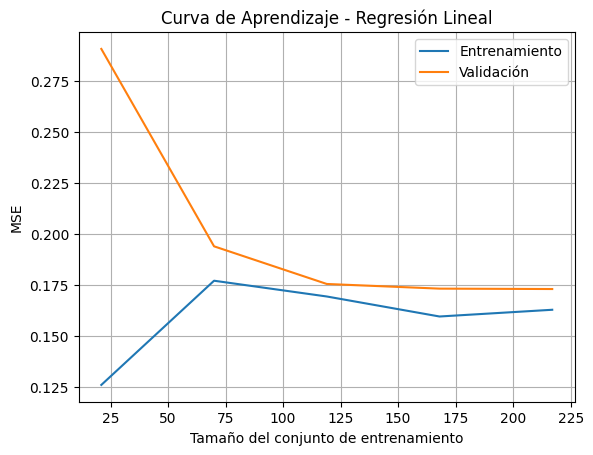

In [4]:
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), x_train, y_train.ravel(), cv=5, scoring='neg_mean_squared_error')
plt.plot(train_sizes, -train_scores.mean(axis=1), label='Entrenamiento')
plt.plot(train_sizes, -val_scores.mean(axis=1), label='Validación')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('MSE')
plt.title('Curva de Aprendizaje - Regresión Lineal')
plt.legend()
plt.grid(True)
plt.show()

## Curva de validación
Muestra el desempeño del modelo para diferentes grados polinómicos (simulación de complejidad).

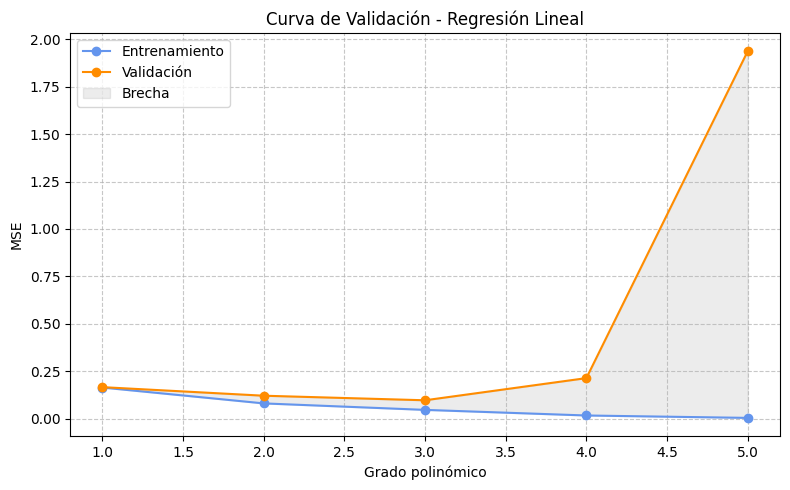

In [13]:
from sklearn.preprocessing import PolynomialFeatures

degrees = np.arange(1, 6)
train_scores, val_scores = [], []
for d in degrees:
    poly = PolynomialFeatures(degree=d)
    x_train_poly = poly.fit_transform(x_train)
    x_val_poly = poly.transform(x_val)
    model = LinearRegression().fit(x_train_poly, y_train)
    train_scores.append(mean_squared_error(y_train, model.predict(x_train_poly)))
    val_scores.append(mean_squared_error(y_val, model.predict(x_val_poly)))

plt.figure(figsize=(8,5))
plt.plot(degrees, train_scores, marker='o', color='cornflowerblue', label='Entrenamiento')
plt.plot(degrees, val_scores, marker='o', color='darkorange', label='Validación')
plt.fill_between(degrees, train_scores, val_scores, color='gray', alpha=0.15, label='Brecha')
plt.xlabel('Grado polinómico')
plt.ylabel('MSE')
plt.title('Curva de Validación - Regresión Lineal')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Curva de paridad
Compara las predicciones del modelo con los valores reales.

> **Nota:**
>
> **MSE** significa *Mean Squared Error* (Error Cuadrático Medio). Es una métrica que mide el promedio de los cuadrados de las diferencias entre los valores reales y los valores predichos por el modelo. Un MSE bajo indica que las predicciones están cerca de los valores reales; un MSE alto indica mayor error de predicción.
>
>El valor óptimo de MSE (Mean Squared Error) depende de la escala de tu variable objetivo (por ejemplo, temperatura en °C o humedad en %). Un MSE ideal es lo más cercano posible a 0, lo que indica que las predicciones son casi perfectas.

>Si tu variable objetivo varía entre 0 y 100, un MSE menor a 1 es excelente, menor a 5 es bueno, y mayor a 10 indica margen de mejora.
>Si la variable tiene un rango menor (por ejemplo, temperatura entre 15 y 25), un >MSE menor a 0.1 es excelente, menor a 1 es aceptable.
>En resumen: el MSE óptimo es el más bajo posible, pero lo “bueno” depende del rango de tus datos. Siempre compáralo con la varianza de la variable objetivo y con modelos base (como predecir la media). Si tu MSE es menor que la varianza de los datos, tu modelo ya está aportando valor.

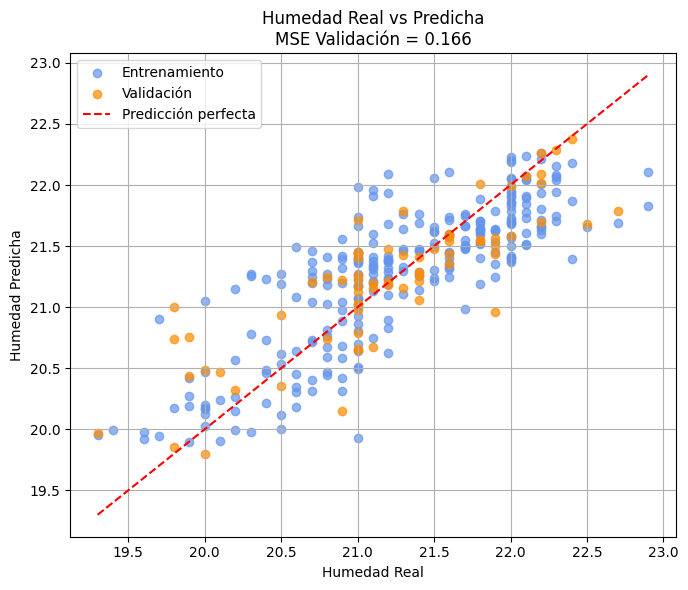

R^2 validación: 0.692


In [10]:
# Curva de paridad mejorada: Humedad Real vs Predicha (Entrenamiento y Validación)
plt.figure(figsize=(7,6))
plt.scatter(y_train, model.predict(x_train), alpha=0.7, label='Entrenamiento', color='cornflowerblue')
plt.scatter(y_val, y_val_pred, alpha=0.7, label='Validación', color='darkorange')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Predicción perfecta')
plt.xlabel('Humedad Real')
plt.ylabel('Humedad Predicha')
plt.title(f'Humedad Real vs Predicha\nMSE Validación = {mean_squared_error(y_val, y_val_pred):.3f}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print(f'R^2 validación: {r2_score(y_val, y_val_pred):.3f}')

## Curva de sesgo y varianza
Analiza la diferencia entre el error de entrenamiento y validación.

In [7]:
y_train_pred = model.predict(x_train)
print(f'MSE Entrenamiento: {mean_squared_error(y_train, y_train_pred):.3f}')
print(f'MSE Validación: {mean_squared_error(y_val, y_val_pred):.3f}')
print(f'R^2 Entrenamiento: {r2_score(y_train, y_train_pred):.3f}')
print(f'R^2 Validación: {r2_score(y_val, y_val_pred):.3f}')

MSE Entrenamiento: 0.164
MSE Validación: 0.166
R^2 Entrenamiento: 0.667
R^2 Validación: 0.692


## Explicación breve
La regresión lineal es un modelo simple y fácil de interpretar. El compromiso sesgo-varianza se observa comparando el error de entrenamiento y validación. Si ambos errores son altos, hay alto sesgo; si hay mucha diferencia, hay alta varianza.

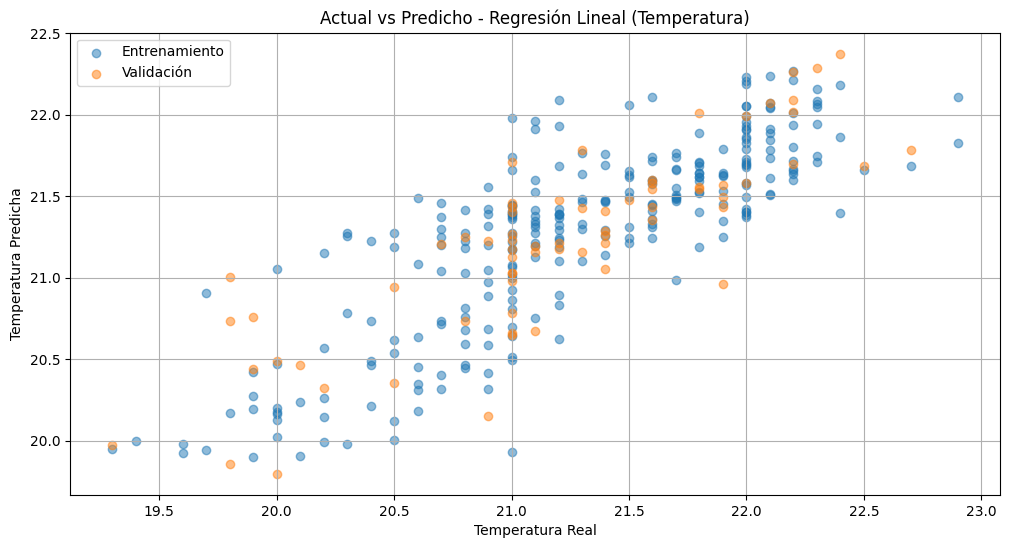

In [16]:
# Actual vs Predicho (Entrenamiento y Validación) - Regresión Lineal (Temperatura)
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.5, label='Entrenamiento')
plt.scatter(y_val, y_val_pred, alpha=0.5, label='Validación')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title('Actual vs Predicho - Regresión Lineal (Temperatura)')
plt.legend()
plt.grid(True)
plt.show()

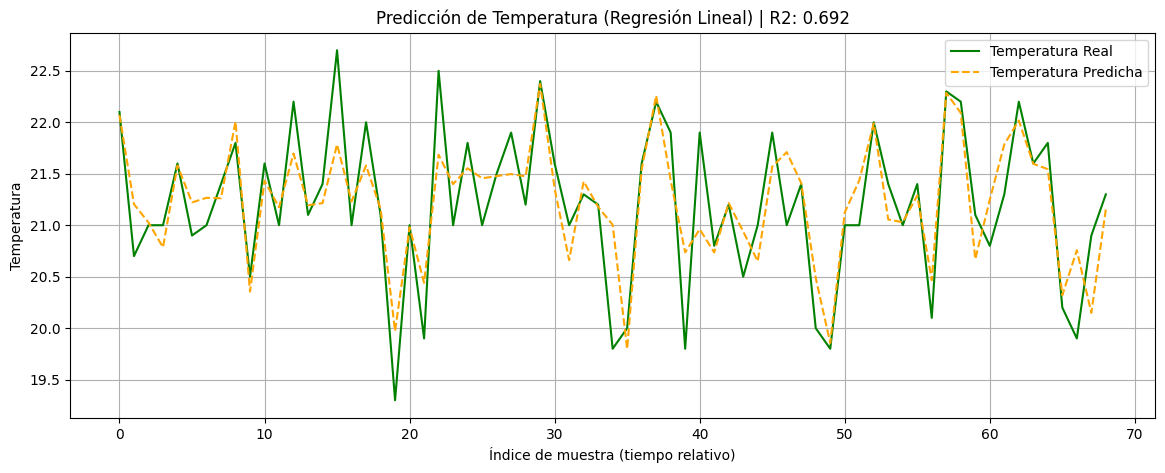

In [17]:
# Serie temporal: Temperatura real vs predicha (validación)
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(y_val)), y_val, label='Temperatura Real', color='green')
plt.plot(np.arange(len(y_val_pred)), y_val_pred, label='Temperatura Predicha', color='orange', linestyle='--')
plt.xlabel('Índice de muestra (tiempo relativo)')
plt.ylabel('Temperatura')
plt.title(f'Predicción de Temperatura (Regresión Lineal) | R2: {r2_score(y_val, y_val_pred):.3f}')
plt.legend()
plt.grid(True)
plt.show()